C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\2459237182.py:85: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections
MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\2459237182.py:85: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections


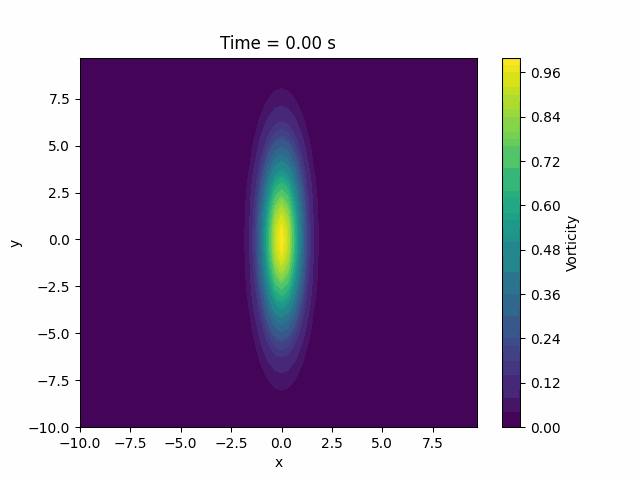

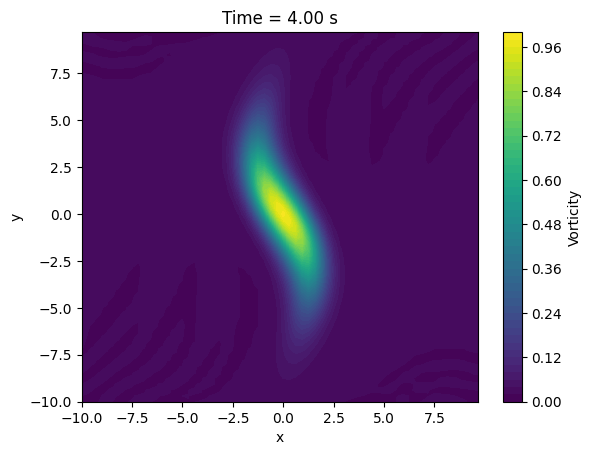

In [61]:
#original LU
import numpy as np
from scipy.sparse import spdiags, kron, eye
from scipy.linalg import lu, solve_triangular
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time
from IPython.display import display, Image  # For displaying GIF inline

# Parameters
L = 20  # Domain size
n = 64  # Number of grid points
dx = L / n  # Grid spacing
nu = 0.001  # Diffusion coefficient
tspan = (0, 4)  # Time span
t_eval = np.linspace(tspan[0], tspan[1], 9)  # 9 time steps
x = np.linspace(-L / 2, L / 2, n, endpoint=False)
y = np.linspace(-L / 2, L / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)

# Initial condition for vorticity
omega0 = np.exp(-X**2 - Y**2 / 20)

# Construct the 2D Laplacian matrix using Kronecker products
e = np.ones(n)
d_x2_1D = spdiags([e, -2 * e, e], [-1, 0, 1], n, n) / dx**2
d_x2_1D = d_x2_1D.tolil()
d_x2_1D[0, -1] = d_x2_1D[-1, 0] = 1 / dx**2  # Periodic BCs
d_x2_1D = d_x2_1D.tocsr()
I = eye(n)
d_x2 = kron(I, d_x2_1D) + kron(d_x2_1D, I)  # 2D Laplacian
A = d_x2.toarray()
A[0, 0] = 2  # Adjust A(0,0)

# LU decomposition
P, L, U = lu(A)

# Function to solve for streamfunction using LU decomposition
def solve_psi_lu(omega):
    b = omega.ravel()  # Flatten omega to match the linear system
    Pb = np.dot(P, b)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    return psi.reshape((n, n))  # Reshape back to 2D

# Function to compute [psi, omega] (Jacobian)
def compute_jacobian(psi, omega):
    psi_x = np.gradient(psi, axis=1) / dx
    psi_y = np.gradient(psi, axis=0) / dx
    omega_x = np.gradient(omega, axis=1) / dx
    omega_y = np.gradient(omega, axis=0) / dx
    return psi_x * omega_y - psi_y * omega_x

# Time derivative function for solve_ivp
def vorticity_rhs_lu(t, omega_flat):
    omega = omega_flat.reshape((n, n))
    psi = solve_psi_lu(omega)
    jacobian = compute_jacobian(psi, omega)
    laplacian_omega = A @ omega.ravel()  # Apply Laplacian operator
    omega_t = -jacobian + nu * laplacian_omega.reshape((n, n))
    return omega_t.ravel()

# Solve using LU decomposition
start_time_lu = time()
solution_lu = solve_ivp(
    vorticity_rhs_lu, tspan, omega0.ravel(), method="RK45", t_eval=t_eval
)
end_time_lu = time()

# Reshape results to the required format
omega_all_lu = solution_lu.y.T.reshape(len(t_eval), n, n)  # (9, 64, 64)

# Visualization and animation setup
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, omega_all_lu[0], levels=50, cmap="viridis")
fig.colorbar(contour, ax=ax, label="Vorticity")

def update(frame):
    ax.clear()  # Clear the previous plot
    contour = ax.contourf(X, Y, omega_all_lu[frame], levels=50, cmap="viridis")
    ax.set_title(f"Time = {t_eval[frame]:.2f} s")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return contour.collections

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), interval=500, blit=True)

# Save the animation as a GIF
gif_path = r"C:\Users\ASUS\Downloads\vorticity_evolution_og.gif"  # Update this path to a valid Windows path
ani.save(gif_path, writer="imagemagick", fps=2)

# Display the GIF inline in the notebook
display(Image(filename=gif_path))

# Show the animation (plot)
plt.show()






C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\988635189.py:91: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\988635189.py:91: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections


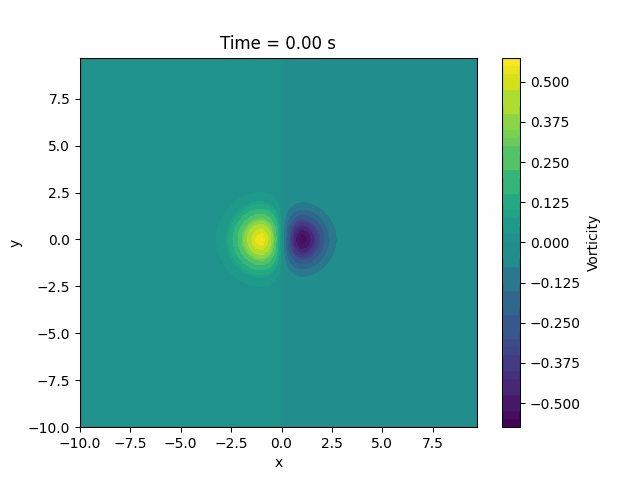

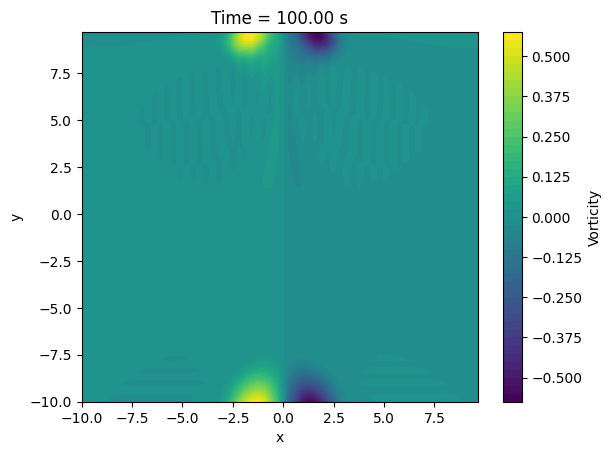

In [62]:
#Two opposite charges next to each other
import numpy as np
from scipy.sparse import spdiags, kron, eye
from scipy.linalg import lu, solve_triangular
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time
from IPython.display import display, Image  # For displaying GIF inline

# Parameters
L = 20  # Domain size
n = 64  # Number of grid points
dx = L / n  # Grid spacing
nu = 0.001  # Diffusion coefficient
tspan = (0, 100)  # Time span
t_eval = np.linspace(tspan[0], tspan[1], 100)  # 9 time steps
x = np.linspace(-L / 2, L / 2, n, endpoint=False)
y = np.linspace(-L / 2, L / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)

# Modified initial condition for vorticity with two oppositely charged vortices
sigma = 1.0  # Standard deviation (width) of the vortices
center1 = (-0.5, 0)  # Position of the positive vortex
center2 = (0.5, 0)   # Position of the negative vortex

# Create two Gaussian vortices: one positive, one negative
omega0 = np.exp(-((X - center1[0])**2 + (Y - center1[1])**2) / (2 * sigma**2))  # Positive vortex
omega0 -= np.exp(-((X - center2[0])**2 + (Y - center2[1])**2) / (2 * sigma**2))  # Negative vortex

# Construct the 2D Laplacian matrix using Kronecker products
e = np.ones(n)
d_x2_1D = spdiags([e, -2 * e, e], [-1, 0, 1], n, n) / dx**2
d_x2_1D = d_x2_1D.tolil()
d_x2_1D[0, -1] = d_x2_1D[-1, 0] = 1 / dx**2  # Periodic BCs
d_x2_1D = d_x2_1D.tocsr()
I = eye(n)
d_x2 = kron(I, d_x2_1D) + kron(d_x2_1D, I)  # 2D Laplacian
A = d_x2.toarray()
A[0, 0] = 2  # Adjust A(0,0)

# LU decomposition
P, L, U = lu(A)

# Function to solve for streamfunction using LU decomposition
def solve_psi_lu(omega):
    b = omega.ravel()  # Flatten omega to match the linear system
    Pb = np.dot(P, b)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    return psi.reshape((n, n))  # Reshape back to 2D

# Function to compute [psi, omega] (Jacobian)
def compute_jacobian(psi, omega):
    psi_x = np.gradient(psi, axis=1) / dx
    psi_y = np.gradient(psi, axis=0) / dx
    omega_x = np.gradient(omega, axis=1) / dx
    omega_y = np.gradient(omega, axis=0) / dx
    return psi_x * omega_y - psi_y * omega_x

# Time derivative function for solve_ivp
def vorticity_rhs_lu(t, omega_flat):
    omega = omega_flat.reshape((n, n))
    psi = solve_psi_lu(omega)
    jacobian = compute_jacobian(psi, omega)
    laplacian_omega = A @ omega.ravel()  # Apply Laplacian operator
    omega_t = -jacobian + nu * laplacian_omega.reshape((n, n))
    return omega_t.ravel()

# Solve using LU decomposition
start_time_lu = time()
solution_lu = solve_ivp(
    vorticity_rhs_lu, tspan, omega0.ravel(), method="RK45", t_eval=t_eval
)
end_time_lu = time()

# Reshape results to the required format
omega_all_lu = solution_lu.y.T.reshape(len(t_eval), n, n)  # (9, 64, 64)

# Visualization and animation setup
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, omega_all_lu[0], levels=50, cmap="viridis")
fig.colorbar(contour, ax=ax, label="Vorticity")

def update(frame):
    ax.clear()  # Clear the previous plot
    contour = ax.contourf(X, Y, omega_all_lu[frame], levels=50, cmap="viridis")
    ax.set_title(f"Time = {t_eval[frame]:.2f} s")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return contour.collections

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), interval=500, blit=True)

# Save the animation as a GIF
gif_path = r"C:\Users\ASUS\Downloads\vorticity_evolution_1.gif"  # Update this path to a valid Windows path
ani.save(gif_path, writer="pillow", fps=2)

# Display the GIF inline in the notebook
display(Image(filename=gif_path))

# Show the animation (plot)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\481330278.py:92: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\481330278.py:92: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections


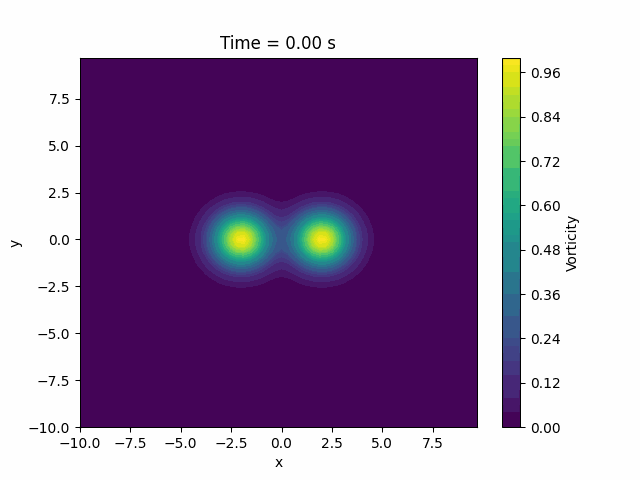

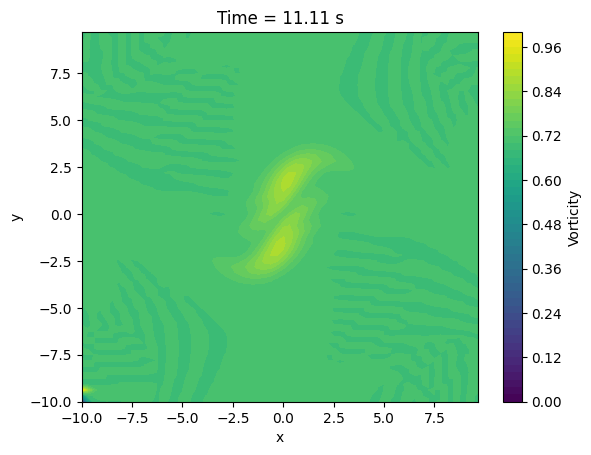

In [63]:
#Two equal charges next to each other
import numpy as np
from scipy.sparse import spdiags, kron, eye
from scipy.linalg import lu, solve_triangular
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time
from IPython.display import display, Image  # For displaying GIF inline

# Parameters
L = 20  # Domain size
n = 64  # Number of grid points
dx = L / n  # Grid spacing
nu = 0.001  # Diffusion coefficient
tspan = (0, 50)  # Time span
t_eval = np.linspace(tspan[0], tspan[1], 100)  # 9 time steps
x = np.linspace(-L / 2, L / 2, n, endpoint=False)
y = np.linspace(-L / 2, L / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)

# Modified initial condition for vorticity with two oppositely charged vortices
sigma = 1.0  # Standard deviation (width) of the vortices
center1 = (-2, 0)  # Position of the positive vortex
center2 = (2, 0)   # Position of the negative vortex

# Create two Gaussian vortices: one positive, one negative
omega0 = np.exp(-((X - center1[0])**2 + (Y - center1[1])**2) / (2 * sigma**2))  # Positive vortex
omega0 += np.exp(-((X - center2[0])**2 + (Y - center2[1])**2) / (2 * sigma**2))  # Negative vortex (added)


# Construct the 2D Laplacian matrix using Kronecker products
e = np.ones(n)
d_x2_1D = spdiags([e, -2 * e, e], [-1, 0, 1], n, n) / dx**2
d_x2_1D = d_x2_1D.tolil()
d_x2_1D[0, -1] = d_x2_1D[-1, 0] = 1 / dx**2  # Periodic BCs
d_x2_1D = d_x2_1D.tocsr()
I = eye(n)
d_x2 = kron(I, d_x2_1D) + kron(d_x2_1D, I)  # 2D Laplacian
A = d_x2.toarray()
A[0, 0] = 2  # Adjust A(0,0)

# LU decomposition
P, L, U = lu(A)

# Function to solve for streamfunction using LU decomposition
def solve_psi_lu(omega):
    b = omega.ravel()  # Flatten omega to match the linear system
    Pb = np.dot(P, b)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    return psi.reshape((n, n))  # Reshape back to 2D

# Function to compute [psi, omega] (Jacobian)
def compute_jacobian(psi, omega):
    psi_x = np.gradient(psi, axis=1) / dx
    psi_y = np.gradient(psi, axis=0) / dx
    omega_x = np.gradient(omega, axis=1) / dx
    omega_y = np.gradient(omega, axis=0) / dx
    return psi_x * omega_y - psi_y * omega_x

# Time derivative function for solve_ivp
def vorticity_rhs_lu(t, omega_flat):
    omega = omega_flat.reshape((n, n))
    psi = solve_psi_lu(omega)
    jacobian = compute_jacobian(psi, omega)
    laplacian_omega = A @ omega.ravel()  # Apply Laplacian operator
    omega_t = -jacobian + nu * laplacian_omega.reshape((n, n))
    return omega_t.ravel()

# Solve using LU decomposition
start_time_lu = time()
solution_lu = solve_ivp(
    vorticity_rhs_lu, tspan, omega0.ravel(), method="RK45", t_eval=t_eval
)
end_time_lu = time()

# Reshape results to the required format
omega_all_lu = solution_lu.y.T.reshape(len(solution_lu.t), n, n)  # Use solution_lu.t for the time steps

# Visualization and animation setup
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, omega_all_lu[0], levels=50, cmap="viridis")
fig.colorbar(contour, ax=ax, label="Vorticity")

def update(frame):
    ax.clear()  # Clear the previous plot
    contour = ax.contourf(X, Y, omega_all_lu[frame], levels=50, cmap="viridis")
    ax.set_title(f"Time = {solution_lu.t[frame]:.2f} s")  # Use solution_lu.t for the actual time
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return contour.collections

# Create the animation
ani = FuncAnimation(fig, update, frames=len(solution_lu.t), interval=500, blit=True)

# Save the animation as a GIF
gif_path = r"C:\Users\ASUS\Downloads\vorticity_evolution_2.gif"  # Update this path to a valid Windows path
ani.save(gif_path, writer="pillow", fps=2)

# Display the GIF inline in the notebook
display(Image(filename=gif_path))

# Show the animation (plot)
plt.show()

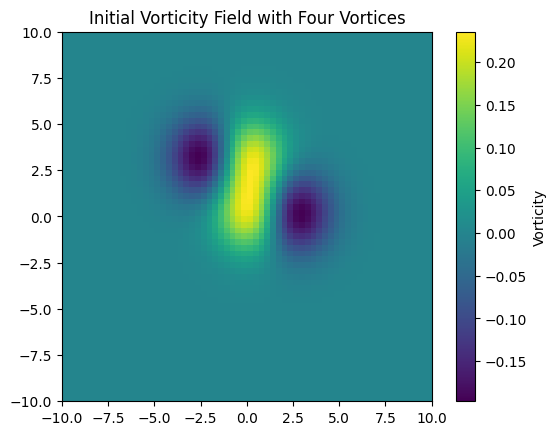

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\4221983565.py:101: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\4221983565.py:101: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections


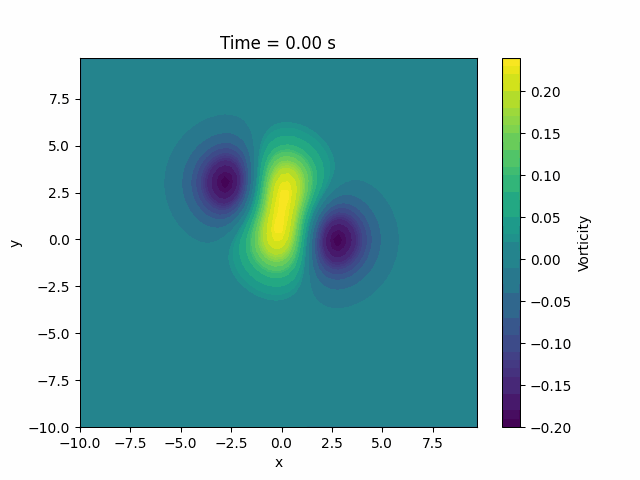

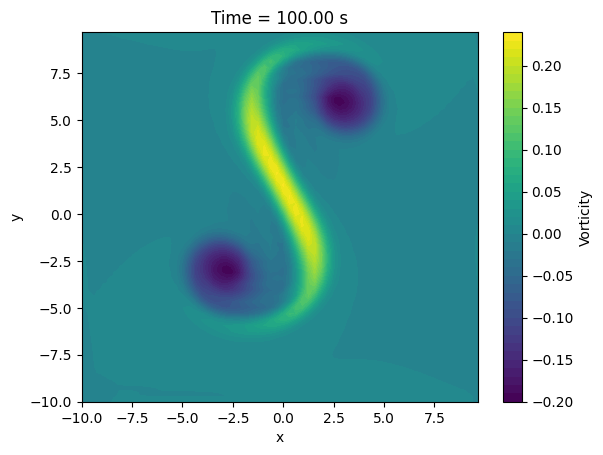

In [64]:
# Two pairs of oppositely charged vortices that can collide
import numpy as np
from scipy.sparse import spdiags, kron, eye
from scipy.linalg import lu, solve_triangular
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time
from IPython.display import display, Image  # For displaying GIF inline

# Parameters
L = 20  # Domain size
n = 64  # Number of grid points
dx = L / n  # Grid spacing
nu = 0.001  # Diffusion coefficient
tspan = (0, 100)  # Time span
t_eval = np.linspace(tspan[0], tspan[1], 100)  # 100 time steps
x = np.linspace(-L / 2, L / 2, n, endpoint=False)
y = np.linspace(-L / 2, L / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)

# Modified initial condition for vorticity with two pairs of oppositely charged vortices
sigma = 1.5  # Standard deviation (width) of the vortices
center1 = (-1, 3)  # Position of the first positive vortex
center2 = (1, 0)   # Position of the second positive vortex
center3 = (-1.5, 3)  # Position of the first negative vortex
center4 = (1.5, 0)   # Position of the second negative vortex

# Create four Gaussian vortices: two positive and two negative
omega0 = np.exp(-((X - center1[0])**2 + (Y - center1[1])**2) / (2 * sigma**2))  # First positive vortex
omega0 += np.exp(-((X - center2[0])**2 + (Y - center2[1])**2) / (2 * sigma**2))  # Second positive vortex
omega0 -= np.exp(-((X - center3[0])**2 + (Y - center3[1])**2) / (2 * sigma**2))  # First negative vortex
omega0 -= np.exp(-((X - center4[0])**2 + (Y - center4[1])**2) / (2 * sigma**2))  # Second negative vortex

# Check the initial vorticity
plt.imshow(omega0, extent=(-L / 2, L / 2, -L / 2, L / 2), origin="lower", cmap="viridis")
plt.colorbar(label="Vorticity")
plt.title("Initial Vorticity Field with Four Vortices")
plt.show()

# Construct the 2D Laplacian matrix using Kronecker products
e = np.ones(n)
d_x2_1D = spdiags([e, -2 * e, e], [-1, 0, 1], n, n) / dx**2
d_x2_1D = d_x2_1D.tolil()
d_x2_1D[0, -1] = d_x2_1D[-1, 0] = 1 / dx**2  # Periodic BCs
d_x2_1D = d_x2_1D.tocsr()
I = eye(n)
d_x2 = kron(I, d_x2_1D) + kron(d_x2_1D, I)  # 2D Laplacian
A = d_x2.toarray()
A[0, 0] = 2  # Adjust A(0,0)

# LU decomposition
P, L, U = lu(A)

# Function to solve for streamfunction using LU decomposition
def solve_psi_lu(omega):
    b = omega.ravel()  # Flatten omega to match the linear system
    Pb = np.dot(P, b)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    return psi.reshape((n, n))  # Reshape back to 2D

# Function to compute [psi, omega] (Jacobian)
def compute_jacobian(psi, omega):
    psi_x = np.gradient(psi, axis=1) / dx
    psi_y = np.gradient(psi, axis=0) / dx
    omega_x = np.gradient(omega, axis=1) / dx
    omega_y = np.gradient(omega, axis=0) / dx
    return psi_x * omega_y - psi_y * omega_x

# Time derivative function for solve_ivp
def vorticity_rhs_lu(t, omega_flat):
    omega = omega_flat.reshape((n, n))
    psi = solve_psi_lu(omega)
    jacobian = compute_jacobian(psi, omega)
    laplacian_omega = A @ omega.ravel()  # Apply Laplacian operator
    omega_t = -jacobian + nu * laplacian_omega.reshape((n, n))
    return omega_t.ravel()

# Solve using LU decomposition
start_time_lu = time()
solution_lu = solve_ivp(
    vorticity_rhs_lu, tspan, omega0.ravel(), method="RK45", t_eval=t_eval
)
end_time_lu = time()

# Reshape results to the required format
omega_all_lu = solution_lu.y.T.reshape(len(solution_lu.t), n, n)  # Use solution_lu.t for the time steps

# Visualization and animation setup
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, omega_all_lu[0], levels=50, cmap="viridis")
fig.colorbar(contour, ax=ax, label="Vorticity")

def update(frame):
    ax.clear()  # Clear the previous plot
    contour = ax.contourf(X, Y, omega_all_lu[frame], levels=50, cmap="viridis")
    ax.set_title(f"Time = {solution_lu.t[frame]:.2f} s")  # Use solution_lu.t for the actual time
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return contour.collections

# Create the animation
ani = FuncAnimation(fig, update, frames=len(solution_lu.t), interval=500, blit=True)

# Save the animation as a GIF
gif_path = r"C:\Users\ASUS\Downloads\vorticity_evolution_3.gif"  # Update this path to a valid Windows path
ani.save(gif_path, writer="pillow", fps=4)

# Display the GIF inline in the notebook
display(Image(filename=gif_path))

# Show the animation (plot)
plt.show()



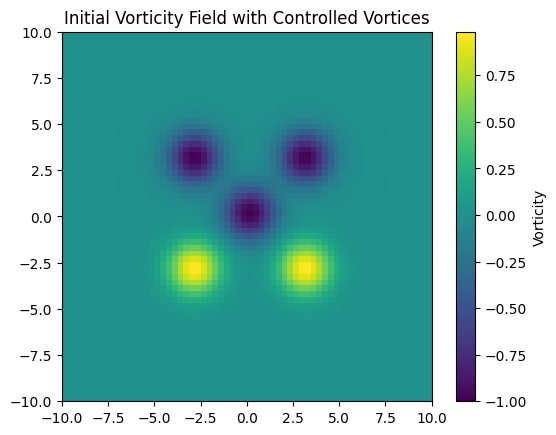

Integration failed: Required step size is less than spacing between numbers.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\1516076632.py:113: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19748\1516076632.py:113: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour.collections


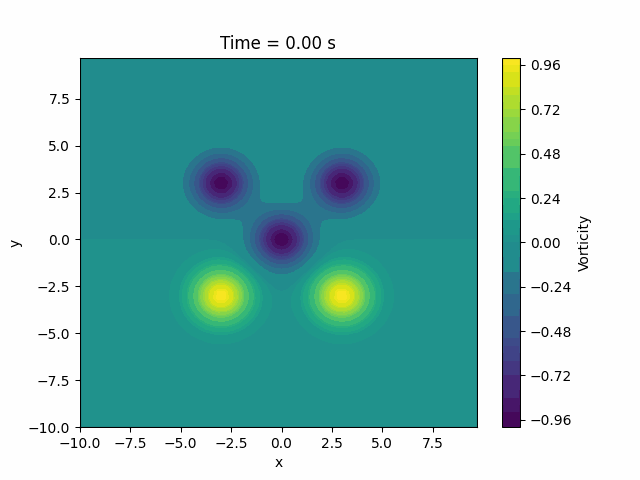

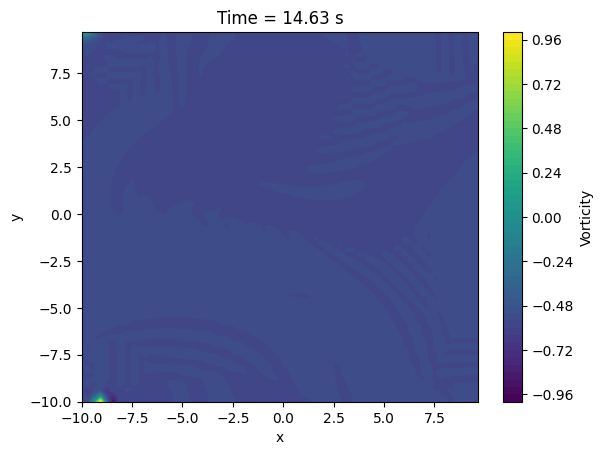

In [65]:
import numpy as np
from scipy.sparse import spdiags, kron, eye
from scipy.linalg import lu, solve_triangular
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time
from IPython.display import display, Image

# Parameters
L = 20  # Domain size
n = 64  # Number of grid points
dx = L / n  # Grid spacing
nu = 0.001  # Diffusion coefficient
tspan = (0, 100)  # Time span
t_eval = np.linspace(tspan[0], tspan[1], 500)  # Increase number of time steps
x = np.linspace(-L / 2, L / 2, n, endpoint=False)
y = np.linspace(-L / 2, L / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)

# Controlled vortex configuration (closer together)
num_vortices = 5  # Number of vortices (simplified)
vortex_positions = np.array([[-3, -3], [3, 3], [3, -3], [-3, 3], [0, 0]])  # Closer positions
vortex_charges = np.array([1, -1, 1, -1, -1])  # Center vortex now has opposite charge (changed to -1)
vortex_strengths = np.array([1.0, 1.0, 1.0, 1.0, 1.0])  # Uniform strengths for stability

# Initialize vorticity field omega0
omega0 = np.zeros((n, n))

# Generate controlled vortices
for i in range(num_vortices):
    x_pos, y_pos = vortex_positions[i]  # Vortex position
    charge = vortex_charges[i]  # Vortex charge
    sigma = vortex_strengths[i]  # Vortex width (uniform for stability)

    # Create the Gaussian vortex
    vortex = charge * np.exp(-(((X - x_pos)**2 + (Y - y_pos)**2) / (2 * sigma**2)))
    omega0 += vortex  # Add vortex to the initial field

# Check the initial vorticity field
plt.imshow(omega0, extent=(-L / 2, L / 2, -L / 2, L / 2), origin="lower", cmap="viridis")
plt.colorbar(label="Vorticity")
plt.title("Initial Vorticity Field with Controlled Vortices")
plt.show()

# Construct the 2D Laplacian matrix using Kronecker products
e = np.ones(n)
d_x2_1D = spdiags([e, -2 * e, e], [-1, 0, 1], n, n) / dx**2
d_x2_1D = d_x2_1D.tolil()
d_x2_1D[0, -1] = d_x2_1D[-1, 0] = 1 / dx**2  # Periodic BCs
d_x2_1D = d_x2_1D.tocsr()
I = eye(n)
d_x2 = kron(I, d_x2_1D) + kron(d_x2_1D, I)  # 2D Laplacian
A = d_x2.toarray()
A[0, 0] = 2  # Adjust A(0,0)

# LU decomposition
P, L, U = lu(A)

# Function to solve for streamfunction using LU decomposition
def solve_psi_lu(omega):
    b = omega.ravel()  # Flatten omega to match the linear system
    Pb = np.dot(P, b)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    return psi.reshape((n, n))  # Reshape back to 2D

# Function to compute [psi, omega] (Jacobian)
def compute_jacobian(psi, omega):
    psi_x = np.gradient(psi, axis=1) / dx
    psi_y = np.gradient(psi, axis=0) / dx
    omega_x = np.gradient(omega, axis=1) / dx
    omega_y = np.gradient(omega, axis=0) / dx
    return psi_x * omega_y - psi_y * omega_x

# Time derivative function for solve_ivp
def vorticity_rhs_lu(t, omega_flat):
    omega = omega_flat.reshape((n, n))
    psi = solve_psi_lu(omega)
    jacobian = compute_jacobian(psi, omega)
    laplacian_omega = A @ omega.ravel()  # Apply Laplacian operator
    omega_t = -jacobian + nu * laplacian_omega.reshape((n, n))
    return omega_t.ravel()

# Solve using LU decomposition with RK45
start_time_lu = time()
solution_lu = solve_ivp(
    vorticity_rhs_lu, tspan, omega0.ravel(), method="RK45", t_eval=t_eval,
    rtol=1e-5, atol=1e-8  # Reduced tolerance for more precision
)
end_time_lu = time()

# Check if solution was successful
if solution_lu.success:
    print("Integration successful!")
else:
    print("Integration failed:", solution_lu.message)

# Reshape results to the required format
omega_all_lu = solution_lu.y.T.reshape(len(solution_lu.t), n, n)  # Use solution_lu.t for the time steps

# Visualization and animation setup
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, omega_all_lu[0], levels=50, cmap="viridis")
fig.colorbar(contour, ax=ax, label="Vorticity")

def update(frame):
    ax.clear()  # Clear the previous plot
    contour = ax.contourf(X, Y, omega_all_lu[frame], levels=50, cmap="viridis")
    ax.set_title(f"Time = {solution_lu.t[frame]:.2f} s")  # Use solution_lu.t for the actual time
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return contour.collections

# Create the animation
ani = FuncAnimation(fig, update, frames=len(solution_lu.t), interval=500, blit=True)

# Save the animation as a GIF
gif_path = r"C:\Users\ASUS\Downloads\vorticity_evolution_controlled_vortices.gif"  # Update this path to a valid Windows path
ani.save(gif_path, writer="pillow", fps=5)

# Display the GIF inline in the notebook
display(Image(filename=gif_path))

# Show the animation (plot)
plt.show()


